In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from fastai.learner import DataLoaders
from fastai.vision.all import Learner
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback
from fastai.callback.progress import CSVLogger
from fastai.metrics import RocAuc
from fastai.optimizer import OptimWrapper
from functools import partial
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = "/Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data/train/track_a/eng.csv"

# Dataset definition
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.texts = data["text"].tolist()
        self.labels = data[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        encodings = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encodings["input_ids"].squeeze(0)
        attention_mask = encodings["attention_mask"].squeeze(0)
        return (input_ids, attention_mask), labels

# TransMIL definition
class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        return nn.functional.normalize(x, dim=-1) * self.scale * self.gamma

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, norm_layer=nn.LayerNorm, dropout=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            norm_layer(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.mlp(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=512 // 8, norm_layer=nn.LayerNorm, dropout=0.):
        super().__init__()
        self.heads = heads
        self.norm = norm_layer(dim)
        self.mhsa = nn.MultiheadAttention(dim, heads, dropout, batch_first=True)

    def forward(self, x, mask=None):
        x = self.norm(x)
        attn_output, _ = self.mhsa(x, x, x, need_weights=False, attn_mask=mask)
        return attn_output

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, norm_layer=nn.LayerNorm, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head, norm_layer=norm_layer, dropout=dropout),
                FeedForward(dim, mlp_dim, norm_layer=norm_layer, dropout=dropout)
            ]) for _ in range(depth)
        ])
        self.norm = norm_layer(dim)

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x_attn = attn(x, mask=mask)
            x = x_attn + x
            x = ff(x) + x
        return self.norm(x)

class TransMIL(nn.Module):
    def __init__(self, *, num_classes: int, input_dim: int = 768, dim: int = 512,
                 depth: int = 2, heads: int = 8, dim_head: int = 64, mlp_dim: int = 2048,
                 pool: str ='cls', dropout: float = 0., emb_dropout: float = 0.):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim, dim, bias=True), nn.GELU())
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, nn.LayerNorm, dropout)
        self.pool = pool
        self.mlp_head = nn.Sequential(nn.Linear(dim, num_classes))

    def forward(self, x, lens):
        b, n, d = x.shape
        x = self.dropout(self.fc(x))
        x = self.transformer(x)
        if self.pool == 'mean':
            x = x.mean(dim=1)
        else:
            x = x[:, 0]
        return self.mlp_head(x)

# Hybrid Model combining BERT and TransMIL
class BertWithTransMIL(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', transmil_config=None):
        super(BertWithTransMIL, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        if transmil_config is None:
            transmil_config = {
                "num_classes": 5,
                "input_dim": 768,
                "dim": 512,
                "depth": 2,
                "heads": 8,
                "dim_head": 64,
                "mlp_dim": 2048,
                "pool": "cls",
                "dropout": 0.1,
                "emb_dropout": 0.1
            }
        self.transmil = TransMIL(**transmil_config)

    def forward(self, x):
        input_ids, attention_mask = x
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = bert_output.last_hidden_state
        seq_lengths = torch.sum(attention_mask, dim=1)
        logits = self.transmil(bert_embeddings, seq_lengths)
        return logits

class CorrelationAwareLoss(nn.Module):
    def __init__(self, pos_weight, correlation_matrix, base_loss=nn.BCEWithLogitsLoss):
        """
        Args:
            pos_weight (torch.Tensor): Weights for positive samples of each class.
            correlation_matrix (torch.Tensor): Correlation matrix of labels.
            base_loss (nn.Module): Base loss function (default: BCEWithLogitsLoss).
        """
        super(CorrelationAwareLoss, self).__init__()
        self.pos_weight = pos_weight
        self.correlation_matrix = correlation_matrix
        self.base_loss = base_loss(pos_weight=self.pos_weight)

    def forward(self, logits, labels):
        # Compute the weighted BCEWithLogitsLoss
        weighted_loss = self.base_loss(logits, labels)

        # Compute pairwise correlation adjustment
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        batch_size = preds.size(0)

        # Penalize based on how predictions align with label correlation
        correlation_loss = torch.sum(
            (preds.unsqueeze(2) - preds.unsqueeze(1)) * self.correlation_matrix.unsqueeze(0)
        ) / batch_size

        # Combine the base loss and correlation loss
        return weighted_loss + 0.1 * correlation_loss

/Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.trans

In [2]:

# Load data
data = pd.read_csv(DATA_PATH)

# Prepare train and validation sets
train_data, valid_data = train_test_split(data, test_size=0.25, random_state=42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = EmotionDataset(
    train_data,
    tokenizer
)
valid_dataset = EmotionDataset(
    valid_data,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

# Define model and training components
device = torch.device("mps")
model = BertWithTransMIL().to(device)


labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]

values = train_data[labels].values.tolist()
# Compute pos_weight for BCEWithLogitsLoss
labels_tensor = torch.tensor(values, dtype=torch.float)
num_positives = labels_tensor.sum(dim=0)
num_negatives = labels_tensor.shape[0] - num_positives
pos_weight = num_negatives / num_positives
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)

# Define the loss function
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

#loss_func = CorrelationAwareLoss(pos_weight=class_weights, correlation_matrix=correlation_matrix)
# loss_func = nn.BCEWithLogitsLoss()


/var/folders/l8/zfmkrkws43d8gb6lx2t5w2rr0000gn/T/ipykernel_7880/2956402097.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)


In [3]:

# FastAI DataLoaders
dls = DataLoaders(train_loader, valid_loader, device=device)
output_path = Path('MIL_BCE_weights')
output_path.mkdir(exist_ok=True, parents=True)

# Define Learner
learn = Learner(
    dls,
    model,
    loss_func=loss_func,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    metrics=[RocAuc()],
    path=output_path
)

# Callbacks
cbs = [
    SaveModelCallback(monitor='valid_loss', fname='best_valid'),
    EarlyStoppingCallback(monitor='valid_loss', patience=9),
    CSVLogger()
]

In [4]:

learn.fit_one_cycle(n_epoch=5, reset_opt=True, lr_max=1e-4, wd=1e-2, cbs=cbs)


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.733023,0.654211,0.821936,01:21
1,0.602248,0.645184,0.822968,01:20
2,0.337249,0.840285,0.826015,01:20
3,0.145541,0.851227,0.825689,01:20
4,0.068382,0.883722,0.822603,01:20


Better model found at epoch 0 with valid_loss value: 0.654211163520813.
Better model found at epoch 1 with valid_loss value: 0.6451835036277771.


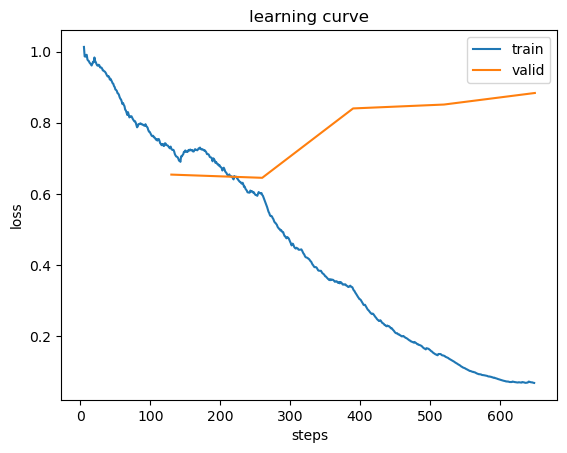

In [5]:

learn.recorder.plot_loss()
plt.show()

In [8]:
import pandas as pd

def predict_and_save_with_texts(learner, texts, output_csv):
    if learner.dls.valid is None:
        raise ValueError("The Learner does not have a validation DataLoader.")
    
    preds, targs = learner.get_preds(dl=learner.dls.valid)

    preds_binary = (preds > 0).int()

    results_df = pd.DataFrame({
        "Text": texts,
        "True Labels": [list(map(int, x)) for x in targs],
        "Predicted Labels": [list(map(int, x)) for x in preds_binary]
    })

    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    return 


best_model_path = output_path / 'models' / 'best_valid.pth'
learn.load(best_model_path.stem)


validation_texts = valid_data["text"].tolist()
predict_and_save_with_texts(learn, validation_texts, output_csv="results_MIL/validation_predictions_with_texts_MIL_weights.csv")


/Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/fastai/learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


Predictions saved to results_MIL/validation_predictions_with_texts_MIL_weights.csv


In [ ]:
model = BertEmotionClassifier(5)
model.load_state_dict(torch.load(f"/Users/vav/Documents/TUD/Semester 3/LLM/Project/{output_path}/models/best_valid.pth"))
model.eval()  # Set the model to evaluation mode


BertEmotionClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [16]:
dev_data_path = "/Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data_dev/track_a/dev/eng.csv"
data = pd.read_csv(dev_data_path)


In [17]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to preprocess and predict
def predict_classes(model, texts, tokenizer, max_len=128):
    """
    Predict classes for a list of texts using the provided model and tokenizer.

    Args:
        model: The loaded PyTorch model.
        texts: A list of input sentences.
        tokenizer: The tokenizer for preprocessing the input.
        max_len: Maximum sequence length for tokenization.

    Returns:
        predictions: Predicted labels for the input texts.
    """
    predictions = []

    with torch.no_grad():
        for text in texts:
            # Tokenize and prepare input
            encoded = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )
            input_ids = encoded["input_ids"]
            attention_mask = encoded["attention_mask"]

            # Make predictions
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)  # Multi-label classification
            predicted_labels = (probs > 0.5).int().tolist()[0]  # Binary predictions

            predictions.append(predicted_labels)
    
    return predictions

# Apply the model to the dataset
texts = data["text"].fillna("").tolist()  # Handle missing texts
predictions = predict_classes(model, texts, tokenizer)

# Add predictions to the DataFrame
emotion_labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
prediction_df = pd.DataFrame(predictions, columns=emotion_labels)
data[emotion_labels] = prediction_df

# Save the updated DataFrame to a new file
output_path = "/Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data_dev/track_a/dev/eng_with_predictions_CAL.csv"
data.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

TypeError: BertEmotionClassifier.forward() takes 2 positional arguments but 3 were given

In [ ]:
# Correct the device for inference
device = torch.device("mps")

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load the trained model and set it to evaluation mode
model = BertEmotionClassifier(5)
model.load_state_dict(torch.load("/Users/vav/Documents/TUD/Semester 3/LLM/Project/MIL_BCE_weights/models/best_valid.pth", map_location=device))
model.to(device)
model.eval()

# Define the function for preprocessing and predicting
def predict_classes(model, texts, tokenizer, max_len=128):
    """
    Predict classes for a list of texts using the provided model and tokenizer.
    """
    predictions = []

    with torch.no_grad():
        for text in texts:
            # Tokenize and prepare input
            encoded = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            # Make predictions
            logits = model((input_ids, attention_mask))
            probs = torch.sigmoid(logits)  # Multi-label classification
            predicted_labels = (probs > 0.5).int().tolist()[0]

            predictions.append(predicted_labels)
    
    return predictions

# Load and preprocess the new dataset
dev_data_path = "/Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data_dev/track_a/dev/eng.csv"
data = pd.read_csv(dev_data_path)
texts = data["text"].fillna("").tolist()  # Handle missing texts

# Make predictions
predictions = predict_classes(model, texts, tokenizer)

# Add predictions to the DataFrame
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]
prediction_df = pd.DataFrame(predictions, columns=emotion_labels)
data[emotion_labels] = prediction_df

# Save the updated DataFrame to a new file
output_path = "/Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data_dev/track_a/dev/eng_with_predictions.csv"
data.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")


Predictions saved to /Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data_dev/track_a/dev/eng_with_predictions.csv
